In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 9.9 MB/s eta 0:00:00


In [3]:
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor, callback

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

from sktime.forecasting.model_selection import temporal_train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

In [4]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/DACON_23.07_PowerConsumption/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
building = pd.read_csv(f"{DATA_PATH}building_info.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

df = pd.read_csv(f"{DATA_PATH}train_featured_3.csv")
train_ft = pd.read_csv(f"{DATA_PATH}train_selected_3.csv")

In [11]:
def _smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    output = np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
    return output
smape = make_scorer(_smape, greater_is_better=False)

In [7]:
train_ft.columns

Index(['day_hour_mean', 'day_hour_median', 'discomfort_CDH', 'week',
       'day_hour_mode', 'discomfort', 'day_hour_std', 'CDH', 'hour_mean',
       'sin_time', 'cos_week', 'day_of_year'],
      dtype='object')

In [10]:
df.columns

Index(['num_date_time', 'building_num', 'date_time', 'temp', 'precip',
       'wind_ms', 'humidity', 'sunshine', 'solar_rad', 'energy_consum',
       'building_type', 'floor_area', 'cooling_area', 'solar_capa', 'ess_capa',
       'pcs_capa', 'hour', 'day', 'month', 'week', 'day_hour_mean',
       'hour_mean', 'hour_std', 'hour_type_mean', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH', 'discomfort', 'discomfort_CDH', 'solar_gen',
       'CDH_solar', 'cooling_ratio', 'day_of_year', 'cos_day_of_year',
       'sin_day_of_year', 'cos_weekday', 'sin_weekday', 'cos_week', 'sin_week',
       'cos_month', 'sin_month', 'day_hour_median', 'day_hour_std',
       'day_hour_mode'],
      dtype='object')

In [15]:
cols = ['day_hour_mean', 'day_hour_median', 'discomfort_CDH', 'week',
       'day_hour_mode', 'discomfort', 'day_hour_std', 'CDH', 'hour_mean',
       'sin_time', 'cos_week', 'day_of_year','building_num','energy_consum']

train_ft = df[cols]

In [301]:
#train_ft : selected feature

# 1부터 36까지의 숫자에 따라 train_ft 데이터프레임을 생성하여 개별 변수로 저장
for i in range(1, 101):
    globals()[f'train_ft_{i}'] = train_ft[train_ft['building_num'] == i]

In [302]:
#df : full feature

# 1부터 36까지의 숫자에 따라 train_ft 데이터프레임을 생성하여 개별 변수로 저장
for i in range(1, 101):
    globals()[f'train_df_{i}'] = df[df['building_num'] == i]

In [18]:
# #test_ft

# # 1부터 36까지의 숫자에 따라 train_ft 데이터프레임을 생성하여 개별 변수로 저장
# for i in range(1, 37):
#     globals()[f'test_df_{i}'] = test_ft[test_ft['building_num'] == i]

NameError: ignored

# --- 건물기타 ---

## 1

In [17]:
train_drop_cols = ['energy_consum','building_num']


In [33]:
train_x = train_ft_1.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_1['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [34]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [35]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2634.583844
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[50]	training's l2: 10935.4	valid_1's l2: 24290.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [36]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [37]:
_smape(y_valid, x_pred)

2.231451607862049

In [ ]:
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
y_pred.shape

## 2

In [38]:
train_drop_cols = ['energy_consum','building_num']


In [39]:
train_x = train_ft_2.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_2['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [40]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [41]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1673.842404
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[89]	training's l2: 5388.08	valid_1's l2: 48833.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [42]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [43]:
_smape(y_valid, x_pred)

4.853289705290241

- 전체 feature 확인

In [98]:
df.columns

Index(['num_date_time', 'building_num', 'date_time', 'temp', 'precip',
       'wind_ms', 'humidity', 'sunshine', 'solar_rad', 'energy_consum',
       'building_type', 'floor_area', 'cooling_area', 'solar_capa', 'ess_capa',
       'pcs_capa', 'hour', 'day', 'month', 'week', 'day_hour_mean',
       'hour_mean', 'hour_std', 'hour_type_mean', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH', 'discomfort', 'discomfort_CDH', 'solar_gen',
       'CDH_solar', 'cooling_ratio', 'day_of_year', 'cos_day_of_year',
       'sin_day_of_year', 'cos_weekday', 'sin_weekday', 'cos_week', 'sin_week',
       'cos_month', 'sin_month', 'day_hour_median', 'day_hour_std',
       'day_hour_mode'],
      dtype='object')

In [99]:
train_drop_cols = ['energy_consum','num_date_time', 'building_num', 'date_time','building_type','floor_area', 'cooling_area','cooling_ratio' ]


In [100]:
train_x = train_df_2.drop(columns=train_drop_cols,axis=1)
train_y = train_df_2['energy_consum']


In [101]:
from xgboost import XGBRegressor
import numpy as np

# 모델 생성 및 훈련
model = XGBRegressor(random_state=42)
model.fit(train_x, train_y)

feature_names = train_x.columns  # 특성의 이름을 저장

# 특성 중요도 출력 및 정렬
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

top_feature_names_xgb = []  # 상위 12개의 특성 이름을 저장할 리스트

print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")

    if i < 12:  # 상위 12개의 특성 이름을 리스트에 추가
        top_feature_names_xgb.append(feature_name)

print("Top 12 Feature Names:", top_feature_names)


Feature Importances:
1. Feature: day_hour_mean, Importance: 0.7817
2. Feature: discomfort_CDH, Importance: 0.0538
3. Feature: week, Importance: 0.0314
4. Feature: day_hour_median, Importance: 0.0202
5. Feature: month, Importance: 0.0158
6. Feature: day_hour_mode, Importance: 0.0125
7. Feature: day_of_year, Importance: 0.0106
8. Feature: sin_week, Importance: 0.0080
9. Feature: CDH, Importance: 0.0078
10. Feature: hour, Importance: 0.0073
11. Feature: cos_day_of_year, Importance: 0.0060
12. Feature: sin_weekday, Importance: 0.0044
13. Feature: hour_mean, Importance: 0.0043
14. Feature: THI, Importance: 0.0042
15. Feature: humidity, Importance: 0.0033
16. Feature: day, Importance: 0.0033
17. Feature: solar_rad, Importance: 0.0030
18. Feature: discomfort, Importance: 0.0029
19. Feature: day_hour_std, Importance: 0.0027
20. Feature: sin_time, Importance: 0.0024
21. Feature: cos_week, Importance: 0.0024
22. Feature: cos_time, Importance: 0.0021
23. Feature: sunshine, Importance: 0.0021
24. 

In [102]:

train_x = train_df_2[top_feature_names_xgb]
train_y = train_df_2['energy_consum']

# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

_smape(y_valid, x_pred)

[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1673.842404
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[68]	training's l2: 7870.94	valid_1's l2: 49498


5.003928234367386

- shap확인

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 1677.016677


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


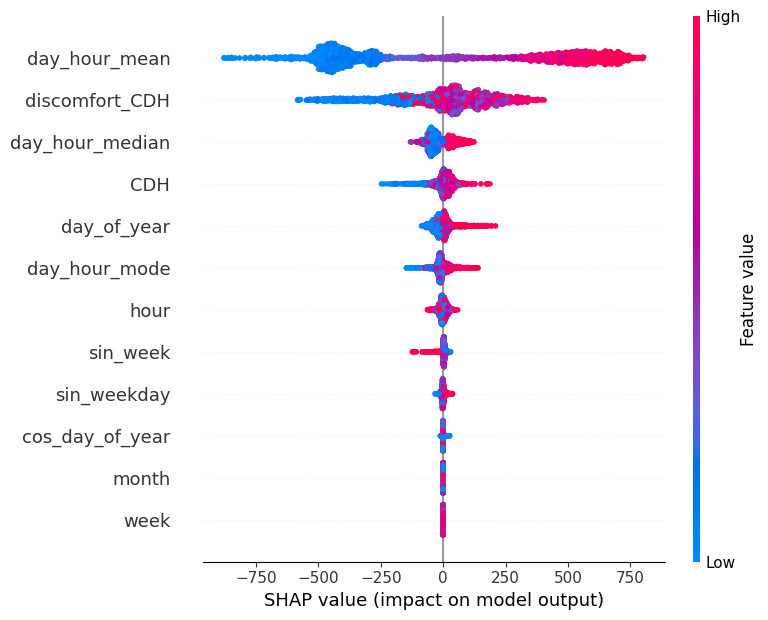

In [103]:
model = LGBMRegressor(random_state=42)
model.fit(train_x, train_y)

# SHAP 값을 계산
explainer = shap.Explainer(model)
shap_values = explainer(train_x)

# SHAP 값을 시각화하여 피쳐 중요도 확인
shap.summary_plot(shap_values, train_x)

In [104]:
# shap_means = np.abs(shap_values.values).mean(axis=0)

# # 결과를 DataFrame으로 저장
# shap_features = pd.DataFrame({'SHAP Features': feature_names, 'SHAP_mean': shap_means})

# # SHAP 평균 순으로 정렬
# shap_features = shap_features.sort_values(by='SHAP_mean', ascending=False)

# shap_features_selected = shap_features['SHAP Features'].iloc[:12]
# print(shap_features)

ValueError: ignored

In [ ]:
# set1 = set(shap_features_selected)
# set2 = set(top_feature_names_xgb)

# # 중복을 제거한 set들을 합치고 다시 리스트로 변환
# xgb_shap_cl_list = list(set1.union(set2))

## 3

In [60]:
train_drop_cols = ['energy_consum','building_num']


In [61]:
train_x = train_ft_3.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_3['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [62]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [63]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1451.631827
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[12]	training's l2: 68855.4	valid_1's l2: 93967.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [64]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [65]:
_smape(y_valid, x_pred)

8.47030605139362

- 전체 feature 확인

In [67]:
train_drop_cols = ['energy_consum','num_date_time', 'building_num', 'date_time','building_type','floor_area', 'cooling_area','cooling_ratio' ]


In [79]:
train_x = train_df_3.drop(columns=train_drop_cols,axis=1)
train_y = train_df_3['energy_consum']


In [80]:
from xgboost import XGBRegressor
import numpy as np

# 모델 생성 및 훈련
model = XGBRegressor(random_state=42)
model.fit(train_x, train_y)

feature_names = train_x.columns  # 특성의 이름을 저장

# 특성 중요도 출력 및 정렬
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

top_feature_names_xgb = []  # 상위 12개의 특성 이름을 저장할 리스트

print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")

    if i < 12:  # 상위 12개의 특성 이름을 리스트에 추가
        top_feature_names_xgb.append(feature_name)

print("Top 12 Feature Names:", top_feature_names)


Feature Importances:
1. Feature: day_hour_mean, Importance: 0.7274
2. Feature: day_hour_median, Importance: 0.0608
3. Feature: week, Importance: 0.0352
4. Feature: discomfort_CDH, Importance: 0.0313
5. Feature: humidity, Importance: 0.0301
6. Feature: month, Importance: 0.0254
7. Feature: sin_week, Importance: 0.0118
8. Feature: day_of_year, Importance: 0.0117
9. Feature: CDH, Importance: 0.0073
10. Feature: sin_weekday, Importance: 0.0067
11. Feature: day_hour_std, Importance: 0.0065
12. Feature: precip, Importance: 0.0046
13. Feature: day, Importance: 0.0045
14. Feature: THI, Importance: 0.0041
15. Feature: day_hour_mode, Importance: 0.0041
16. Feature: hour_std, Importance: 0.0034
17. Feature: cos_week, Importance: 0.0031
18. Feature: discomfort, Importance: 0.0030
19. Feature: solar_rad, Importance: 0.0028
20. Feature: cos_weekday, Importance: 0.0025
21. Feature: cos_time, Importance: 0.0022
22. Feature: sin_time, Importance: 0.0019
23. Feature: temp, Importance: 0.0019
24. Feature

In [74]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.2 MB/s eta 0:00:00


In [76]:
import shap

In [89]:
# set1 = set(shap_features_selected)
# set2 = set(top_feature_names_xgb)

# # 중복을 제거한 set들을 합치고 다시 리스트로 변환
# xgb_shap_cl_list = list(set1.union(set2))

In [91]:
train_x = train_df_2[top_feature_names_xgb]
train_y = train_df_2['energy_consum']

# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

_smape(y_valid, x_pred)

[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1673.842404
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[29]	training's l2: 15238.5	valid_1's l2: 52095.5


4.471289174729839

In [ ]:
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
y_pred.shape

## 4

In [105]:
train_drop_cols = ['energy_consum','building_num']


In [106]:
train_x = train_ft_4.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_4['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [107]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [108]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 992.761106
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[94]	training's l2: 475.407	valid_1's l2: 3435.29


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [109]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [110]:
_smape(y_valid, x_pred)

2.414068309563586

## 5

In [111]:
train_drop_cols = ['energy_consum','building_num']


In [112]:
train_x = train_ft_5.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_5['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [113]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [114]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2713.622113
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[31]	training's l2: 53525.1	valid_1's l2: 61997


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [115]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [116]:
_smape(y_valid, x_pred)

3.0834443836348076

## 6

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [117]:
train_x = train_ft_6.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_6['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [118]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [119]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1963.633590
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[37]	training's l2: 4406.16	valid_1's l2: 21298.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [120]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [121]:
_smape(y_valid, x_pred)

2.164876055806027

## 7

In [122]:
train_drop_cols = ['energy_consum','building_num']


In [123]:
train_x = train_ft_7.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_7['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [124]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [125]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 780.312692
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[57]	training's l2: 1241.6	valid_1's l2: 6289.19


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [126]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [127]:
_smape(y_valid, x_pred)

3.867585309019667

## 8

In [128]:
train_drop_cols = ['energy_consum','building_num']


In [129]:
train_x = train_ft_8.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_8['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [130]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [131]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1324.573975
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[19]	training's l2: 4963.85	valid_1's l2: 8332.82


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [132]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [133]:
_smape(y_valid, x_pred)

2.5318109561457107

## 9

In [134]:
train_drop_cols = ['energy_consum','building_num']


In [135]:
train_x = train_ft_9.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_9['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [136]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [621]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 820.772565
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[88]	training's l2: 747.521	valid_1's l2: 3296.06


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [138]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [139]:
_smape(y_valid, x_pred)

2.318074555540704

## 10

In [140]:
train_drop_cols = ['energy_consum','building_num']


In [141]:
train_x = train_ft_10.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_10['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [142]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [143]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 4060.388333
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[5]	training's l2: 144088	valid_1's l2: 189606


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [144]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [145]:
_smape(y_valid, x_pred)

4.575918575207777

## 11

In [146]:
train_drop_cols = ['energy_consum','building_num']


In [152]:
train_x = train_ft_11.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_11['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [153]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [154]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1929.538205
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[29]	training's l2: 3903.52	valid_1's l2: 7124.27


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [155]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [156]:
_smape(y_valid, x_pred)

1.5708881278004534

## 12

In [157]:
train_drop_cols = ['energy_consum','building_num']


In [158]:
train_x = train_ft_12.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_12['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [159]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [160]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1435.420865
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[36]	training's l2: 2075.75	valid_1's l2: 8563.85


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [161]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [162]:
_smape(y_valid, x_pred)

2.116755028247976

## 13

In [163]:
train_drop_cols = ['energy_consum','building_num']


In [164]:
train_x = train_ft_13.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_13['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [165]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [166]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2529.188590
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[24]	training's l2: 16440.3	valid_1's l2: 33023.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [167]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [168]:
_smape(y_valid, x_pred)

2.8319164443171183

## 14

In [169]:
train_drop_cols = ['energy_consum','building_num']


In [170]:
train_x = train_ft_14.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_14['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [171]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [172]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1914.809486
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[9]	training's l2: 91993.3	valid_1's l2: 141757


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [173]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [174]:
_smape(y_valid, x_pred)

8.739919902436462

## 15

In [175]:
train_drop_cols = ['energy_consum','building_num']


In [176]:
train_x = train_ft_15.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_15['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [177]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [178]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1780.052451
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[29]	training's l2: 2664.04	valid_1's l2: 4569.33


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [179]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [180]:
_smape(y_valid, x_pred)

1.4961049792169783

# --- 공공 ---

## 16

In [181]:
train_drop_cols = ['energy_consum','building_num']


In [182]:
train_x = train_ft_16.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_16['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [183]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [184]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3396.066157
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 36889.7	valid_1's l2: 44644.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [185]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [186]:
_smape(y_valid, x_pred)

3.204330332694696

## 17

In [187]:
train_drop_cols = ['energy_consum','building_num']


In [188]:
train_x = train_ft_17.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_17['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [189]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [190]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 972.798702
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[62]	training's l2: 1111.42	valid_1's l2: 29449.2


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [191]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [192]:
_smape(y_valid, x_pred)

5.14710420539651

## 18

In [193]:
train_drop_cols = ['energy_consum','building_num']


In [194]:
train_x = train_ft_18.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_18['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [195]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [196]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1442.441747
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[52]	training's l2: 2451.56	valid_1's l2: 34304.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [197]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [198]:
_smape(y_valid, x_pred)

3.7048205707781876

## 19

In [199]:
train_drop_cols = ['energy_consum','building_num']


In [200]:
train_x = train_ft_19.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_19['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [201]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [202]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1412.958597
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[80]	training's l2: 1152.2	valid_1's l2: 64945.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [203]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [204]:
_smape(y_valid, x_pred)

5.304662395810789

## 20

In [205]:
train_drop_cols = ['energy_consum','building_num']


In [206]:
train_x = train_ft_20.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_20['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [207]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [208]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1713.578463
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[54]	training's l2: 5874.02	valid_1's l2: 87788


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [209]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [210]:
_smape(y_valid, x_pred)

3.5242480221810415

## 21

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [211]:
train_x = train_ft_21.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_21['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [212]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [213]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1980.851889
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[51]	training's l2: 6874.74	valid_1's l2: 46373.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [214]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [215]:
_smape(y_valid, x_pred)

3.7530552839188407

## 22

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [216]:
train_x = train_ft_22.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_22['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [217]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [218]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1233.682693
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[26]	training's l2: 2728.62	valid_1's l2: 7506.85


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [219]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [220]:
_smape(y_valid, x_pred)

2.3633307301617728

## 23

In [221]:
train_drop_cols = ['energy_consum','building_num']


In [222]:
train_x = train_ft_12.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_12['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [223]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [224]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1435.420865
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[36]	training's l2: 2075.75	valid_1's l2: 8563.85


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [225]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [226]:
_smape(y_valid, x_pred)

2.116755028247976

## 24

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [227]:
train_x = train_ft_24.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_24['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [228]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [229]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 10008.232696
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[65]	training's l2: 26791.1	valid_1's l2: 407541


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [230]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [231]:
_smape(y_valid, x_pred)

1.7904532794579697

## 25

In [232]:
train_drop_cols = ['energy_consum','building_num']


In [234]:
train_x = train_ft_25.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_25['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [235]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [236]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 7239.035765
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[53]	training's l2: 25568	valid_1's l2: 252636


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [237]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [238]:
_smape(y_valid, x_pred)

2.1129540779151554

## 26

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [239]:
train_x = train_ft_26.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_26['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [240]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [241]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3524.546410
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[48]	training's l2: 6421.27	valid_1's l2: 65429.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [242]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [243]:
_smape(y_valid, x_pred)

1.7426484208066966

## 27

In [244]:
train_drop_cols = ['energy_consum','building_num']


In [245]:
train_x = train_ft_27.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_27['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [246]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [247]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 17427.762381
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[56]	training's l2: 53368.3	valid_1's l2: 629630


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [248]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [249]:
_smape(y_valid, x_pred)

1.5241064626461576

## 28

In [250]:
train_drop_cols = ['energy_consum','building_num']


In [252]:
train_x = train_ft_28.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_28['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [253]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [254]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1738.069039
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[38]	training's l2: 6779.99	valid_1's l2: 10733.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [255]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [256]:
_smape(y_valid, x_pred)

2.4688528211161915

## 29

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [257]:
train_x = train_ft_29.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_29['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [258]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [259]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1450.710978
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[52]	training's l2: 1680.28	valid_1's l2: 13197.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [260]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [261]:
_smape(y_valid, x_pred)

2.3240832809865646

## 30

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [262]:
train_x = train_ft_30.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_30['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [263]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [264]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 839.850401
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[48]	training's l2: 1965.09	valid_1's l2: 12333.2


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [265]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [266]:
_smape(y_valid, x_pred)

4.3617305364450925

## 31

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [267]:
train_x = train_ft_31.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_31['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [268]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [269]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1360.217210
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[34]	training's l2: 3297.24	valid_1's l2: 8062.36


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [270]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [271]:
_smape(y_valid, x_pred)

2.5903480871750144

## 32

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [272]:
train_x = train_ft_32.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_32['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [273]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [274]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 9863.655566
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[92]	training's l2: 279.846	valid_1's l2: 5176.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [275]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [276]:
_smape(y_valid, x_pred)

0.2869756567290568

## 33

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [277]:
train_x = train_ft_33.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_33['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [278]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [279]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 8694.078069
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[44]	training's l2: 375.186	valid_1's l2: 1229.01


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [280]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [281]:
_smape(y_valid, x_pred)

0.1566905020719347

## 34

In [282]:
train_drop_cols = ['energy_consum','building_num']


In [283]:
train_x = train_ft_34.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_34['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [284]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [285]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3350.502691
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[21]	training's l2: 874.434	valid_1's l2: 1139.19


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [286]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [287]:
_smape(y_valid, x_pred)

0.38982580057118

## 35

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [288]:
train_x = train_ft_35.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_35['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [289]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [290]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1481
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2171.357052
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[75]	training's l2: 27.5985	valid_1's l2: 171.098


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [291]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [292]:
_smape(y_valid, x_pred)

0.2488262199935984

## 36

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [293]:
train_x = train_ft_36.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_36['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [294]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [295]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2892.460448
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[44]	training's l2: 83.8226	valid_1's l2: 280.46


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [296]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [297]:
_smape(y_valid, x_pred)

0.22040637744005104

## 37

In [300]:
train_drop_cols = ['energy_consum','building_num']


In [303]:
train_x = train_ft_37.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_37['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [304]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [305]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3341.783492
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[51]	training's l2: 17570.3	valid_1's l2: 106628


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [306]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [307]:
_smape(y_valid, x_pred)

2.3426175929449187

## 38

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [308]:
train_x = train_ft_38.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_38['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [309]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [310]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1805.747500
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[98]	training's l2: 3231.99	valid_1's l2: 7175.32


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [311]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [312]:
_smape(y_valid, x_pred)

1.9524974772677588

## 39

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [313]:
train_x = train_ft_39.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_39['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [314]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [315]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2164.378719
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[99]	training's l2: 1920.54	valid_1's l2: 49968.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [316]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [317]:
_smape(y_valid, x_pred)

3.0628340475684097

## 40

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [318]:
train_x = train_ft_40.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_40['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [319]:

# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [320]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1878.003046
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 51835.7	valid_1's l2: 38412


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [321]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [322]:
_smape(y_valid, x_pred)

5.242813534753072

## 41

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [323]:
train_x = train_ft_41.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_41['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [324]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [325]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3254.726122
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[78]	training's l2: 8954.16	valid_1's l2: 26470.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [326]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [327]:
_smape(y_valid, x_pred)

2.018454865052121

## 42

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [328]:
train_x = train_ft_42.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_42['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [329]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [330]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1602.286537
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[17]	training's l2: 61933.9	valid_1's l2: 263313


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [331]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [332]:
_smape(y_valid, x_pred)

14.187958364571095

## 43

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [333]:
train_x = train_ft_43.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_43['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [334]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [335]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1885.231895
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[90]	training's l2: 1316.57	valid_1's l2: 5804.94


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [336]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [337]:
_smape(y_valid, x_pred)

2.2500049857101105

## 44

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [338]:
train_x = train_ft_44.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_44['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [339]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [340]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2122.372820
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[31]	training's l2: 6630.62	valid_1's l2: 10470.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [341]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [342]:
_smape(y_valid, x_pred)

3.3111575542104257

## 45

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [343]:
train_x = train_ft_45.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_45['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [344]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [345]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2942.071024
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[33]	training's l2: 4544.18	valid_1's l2: 8600.76


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [346]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [347]:
_smape(y_valid, x_pred)

1.1134363326324

## 46

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [348]:
train_x = train_ft_46.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_46['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [349]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [350]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2242.025000
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[34]	training's l2: 6379.2	valid_1's l2: 32803.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [351]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [352]:
_smape(y_valid, x_pred)

2.7436669210097713

## 47

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [353]:
train_x = train_ft_47.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_47['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [354]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [355]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 5370.090128
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[48]	training's l2: 11196.4	valid_1's l2: 106057


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [356]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [357]:
_smape(y_valid, x_pred)

2.3348761403894818

## 48

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [358]:
train_x = train_ft_48.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_48['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [359]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [360]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1876.627309
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[45]	training's l2: 1186.23	valid_1's l2: 3929.55


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [361]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [362]:
_smape(y_valid, x_pred)

1.1301322843134722

## 49

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [363]:
train_x = train_ft_49.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_49['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [364]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [365]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3037.270386
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[44]	training's l2: 2257.14	valid_1's l2: 9586.48


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [366]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [367]:
_smape(y_valid, x_pred)

1.2444804039093795

## 50

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [368]:
train_x = train_ft_50.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_50['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [369]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [370]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3022.480447
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[30]	training's l2: 3972.84	valid_1's l2: 9346.82


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [371]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [372]:
_smape(y_valid, x_pred)

1.337830206022018

## 51

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [373]:
train_x = train_ft_51.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_51['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [374]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [375]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2637.836057
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[79]	training's l2: 2066.17	valid_1's l2: 23937.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [376]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [377]:
_smape(y_valid, x_pred)

2.1733077004938943

## 52

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [378]:
train_x = train_ft_52.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_52['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [379]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [380]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2095.868108
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[63]	training's l2: 2810.04	valid_1's l2: 15711.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [381]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [382]:
_smape(y_valid, x_pred)

1.8990752613971766

## 53

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [383]:
train_x = train_ft_53.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_53['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [384]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [385]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1996.396025
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 45938	valid_1's l2: 189502


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [386]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [387]:
_smape(y_valid, x_pred)

9.889251150784506

## 54

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [388]:
train_x = train_ft_54.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_54['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [389]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [390]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1807.779328
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[14]	training's l2: 87450.4	valid_1's l2: 833396


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [391]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [393]:
_smape(y_valid, x_pred)

17.316092183808877

## 55

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [394]:
train_x = train_ft_55.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_55['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [395]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [396]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1008.273398
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[46]	training's l2: 94.1202	valid_1's l2: 677.527


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [397]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [398]:
_smape(y_valid, x_pred)

0.9107744707146657

## 56

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [399]:
train_x = train_ft_56.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_56['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [400]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [401]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 4169.519999
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[41]	training's l2: 1266.81	valid_1's l2: 2271.91


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [402]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [403]:
_smape(y_valid, x_pred)

0.47331469894109374

## 57

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [404]:
train_x = train_ft_57.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_57['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [405]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [406]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1899.888556
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[34]	training's l2: 7813.9	valid_1's l2: 17481.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [407]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [408]:
_smape(y_valid, x_pred)

2.706628282617147

## 58

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [409]:
train_x = train_ft_58.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_58['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [410]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [411]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2880.324870
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[62]	training's l2: 98.2376	valid_1's l2: 415.512


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [412]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [413]:
_smape(y_valid, x_pred)

0.2465109916279197

## 59

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [414]:
train_x = train_ft_59.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_59['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [415]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [416]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1654.332404
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[33]	training's l2: 16252.5	valid_1's l2: 76746.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [417]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [418]:
_smape(y_valid, x_pred)

3.369302100439365

## 60

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [419]:
train_x = train_ft_60.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_60['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [420]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [421]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2930.641282
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[34]	training's l2: 15400.3	valid_1's l2: 33594.2


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [422]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [423]:
_smape(y_valid, x_pred)

2.2451911889492115

## 61

In [424]:
train_drop_cols = ['energy_consum','building_num']


In [425]:
train_x = train_ft_61.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_61['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [426]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [427]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3106.595767
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[32]	training's l2: 13590.4	valid_1's l2: 38936


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [428]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [429]:
_smape(y_valid, x_pred)

2.226324994834431

## 62

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [430]:
train_x = train_ft_62.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_62['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [431]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [432]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1144.295578
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[51]	training's l2: 830.353	valid_1's l2: 6508.15


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [433]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [434]:
_smape(y_valid, x_pred)

2.3529655731355197

## 63

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [623]:
train_x = train_ft_63.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_63['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [624]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [625]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 752.697741
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[97]	training's l2: 210.461	valid_1's l2: 2539.64


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [626]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [627]:
_smape(y_valid, x_pred)

2.7093836631448136

## 64

In [440]:
train_drop_cols = ['energy_consum','building_num']


In [441]:
train_x = train_ft_12.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_12['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [442]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [443]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1435.420865
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[36]	training's l2: 2075.75	valid_1's l2: 8563.85


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [444]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [445]:
_smape(y_valid, x_pred)

2.116755028247976

## 65

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [446]:
train_x = train_ft_65.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_65['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [447]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [448]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 567.170097
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[21]	training's l2: 3069.76	valid_1's l2: 6829.03


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [449]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [450]:
_smape(y_valid, x_pred)

4.971379565187107

## 66

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [451]:
train_x = train_ft_66.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_66['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [452]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [453]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 396.547884
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 31.4345	valid_1's l2: 360.712


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [454]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [455]:
_smape(y_valid, x_pred)

1.7040880739714677

## 67

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [456]:
train_x = train_ft_67.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_67['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [457]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [458]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1282.730320
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[11]	training's l2: 17787.8	valid_1's l2: 21556.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [459]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [460]:
_smape(y_valid, x_pred)

5.41556923364647

## 68

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [461]:
train_x = train_ft_68.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_68['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [462]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [463]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2021.266506
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[48]	training's l2: 2453.24	valid_1's l2: 20250.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [464]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [465]:
_smape(y_valid, x_pred)

2.411900911097016

## 69

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [466]:
train_x = train_ft_69.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_69['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [467]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [468]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 4482.963461
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[45]	training's l2: 13940.1	valid_1's l2: 87445


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [469]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [470]:
_smape(y_valid, x_pred)

1.942005988308884

## 70

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [471]:
train_x = train_ft_70.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_70['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [472]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [473]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 4269.895393
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[43]	training's l2: 15531.9	valid_1's l2: 152640


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [474]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [475]:
_smape(y_valid, x_pred)

2.099338369699532

## 71

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [476]:
train_x = train_ft_71.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_71['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [477]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [478]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2129.925259
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[64]	training's l2: 4311.39	valid_1's l2: 26468.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [479]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [480]:
_smape(y_valid, x_pred)

2.3567713974290965

## 72

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [481]:
train_x = train_ft_72.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_72['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [482]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [483]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1268.978463
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[35]	training's l2: 687.986	valid_1's l2: 7469.34


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [484]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [485]:
_smape(y_valid, x_pred)

2.159448101634035

## 73

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [486]:
train_x = train_ft_73.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_73['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [487]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [488]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 3617.683331
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[25]	training's l2: 9331.77	valid_1's l2: 28565.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [489]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [490]:
_smape(y_valid, x_pred)

1.8038365758012584

## 74

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [491]:
train_x = train_ft_74.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_74['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [492]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [493]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 4002.030391
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[59]	training's l2: 23669.2	valid_1's l2: 344135


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [494]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [495]:
_smape(y_valid, x_pred)

3.990469341193559

## 75

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [496]:
train_x = train_ft_75.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_75['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [497]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [498]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1404.004871
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[27]	training's l2: 6533.17	valid_1's l2: 7768.49


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [499]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [500]:
_smape(y_valid, x_pred)

1.9801131129552414

## 76

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [501]:
train_x = train_ft_76.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_76['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [502]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [503]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1194.931347
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[15]	training's l2: 5358.7	valid_1's l2: 5724.42


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [504]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [505]:
_smape(y_valid, x_pred)

2.202308241556297

## 77

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [506]:
train_x = train_ft_77.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_77['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [507]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [508]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1480.807501
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[33]	training's l2: 2871.69	valid_1's l2: 15079.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [509]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [510]:
_smape(y_valid, x_pred)

2.1473506247361884

## 78

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [511]:
train_x = train_ft_78.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_78['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [628]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [629]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 752.697741
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[97]	training's l2: 210.461	valid_1's l2: 2539.64


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [514]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [515]:
_smape(y_valid, x_pred)

2.3334290754333002

## 79



In [630]:
train_drop_cols = ['energy_consum','building_num']


In [632]:
train_x = train_ft_79.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_79['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [633]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [634]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2882.323458
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[76]	training's l2: 2197.62	valid_1's l2: 39494.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [635]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [636]:
_smape(y_valid, x_pred)

1.5832086098710378

## 80

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [516]:
train_x = train_ft_80.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_80['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [517]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [518]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2536.472883
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[51]	training's l2: 9811.94	valid_1's l2: 102206


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [519]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [520]:
_smape(y_valid, x_pred)

2.905868087015731

## 81

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [521]:
train_x = train_ft_81.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_81['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [522]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [523]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1440.172499
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[87]	training's l2: 1418.63	valid_1's l2: 5976.18


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [524]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [525]:
_smape(y_valid, x_pred)

1.779869038578093

## 82

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [526]:
train_x = train_ft_82.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_82['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [527]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [528]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2273.020383
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[49]	training's l2: 6818.57	valid_1's l2: 59512.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [529]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [530]:
_smape(y_valid, x_pred)

3.714889374976349

## 83

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [531]:
train_x = train_ft_83.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_83['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [532]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [533]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1437.338622
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[44]	training's l2: 4346.56	valid_1's l2: 47879.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [534]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [535]:
_smape(y_valid, x_pred)

3.262422301688321

## 84

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [536]:
train_x = train_ft_84.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_84['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [537]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [538]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1714.789232
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[53]	training's l2: 2405.02	valid_1's l2: 41165.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [539]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [540]:
_smape(y_valid, x_pred)

2.534457441072522

## 85

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [541]:
train_x = train_ft_85.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_85['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [542]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [543]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2246.245191
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[91]	training's l2: 1111.94	valid_1's l2: 9646.98


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [544]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [545]:
_smape(y_valid, x_pred)

1.6837342098061332

## 86

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [546]:
train_x = train_ft_86.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_86['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [547]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [548]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1143.796826
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[99]	training's l2: 955.295	valid_1's l2: 12363.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [549]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [550]:
_smape(y_valid, x_pred)

3.8110470952683286

## 87

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [551]:
train_x = train_ft_87.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_87['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [552]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [553]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1274.642068
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 15884.8	valid_1's l2: 23108


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [554]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [555]:
_smape(y_valid, x_pred)

4.6958632689907915

## 88

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [556]:
train_x = train_ft_88.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_88['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [557]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [558]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1190.265915
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[18]	training's l2: 18641.2	valid_1's l2: 71411.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [559]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [560]:
_smape(y_valid, x_pred)

7.722849942382252

## 89

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [561]:
train_x = train_ft_89.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_89['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [562]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [563]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1426.763717
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[20]	training's l2: 30542.3	valid_1's l2: 118673


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [564]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [565]:
_smape(y_valid, x_pred)

7.078539274974892

## 90

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [566]:
train_x = train_ft_90.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_90['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [567]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [568]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1375.696412
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[30]	training's l2: 19828.3	valid_1's l2: 65215.2


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [569]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [570]:
_smape(y_valid, x_pred)

4.535332153727575

## 91

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [571]:
train_x = train_ft_91.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_91['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [572]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [573]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1320.696409
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[28]	training's l2: 9291.18	valid_1's l2: 44652


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [574]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [575]:
_smape(y_valid, x_pred)

6.705576717515309

## 92

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [576]:
train_x = train_ft_92.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_92['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [577]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [578]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1286.057501
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[20]	training's l2: 13653.9	valid_1's l2: 44941.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [579]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [580]:
_smape(y_valid, x_pred)

5.576609110272622

## 93

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [581]:
train_x = train_ft_93.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_93['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [582]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [583]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1099.958654
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[49]	training's l2: 781.564	valid_1's l2: 7664.53


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [584]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [585]:
_smape(y_valid, x_pred)

3.100948912298738

## 94

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [586]:
train_x = train_ft_94.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_94['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [587]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [588]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2442.008075
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 16777.6	valid_1's l2: 53238.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [589]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [590]:
_smape(y_valid, x_pred)

3.6452202661818665

## 95

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [591]:
train_x = train_ft_95.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_95['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [592]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [593]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1111.251442
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 18656.8	valid_1's l2: 49258.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [594]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [595]:
_smape(y_valid, x_pred)

8.355746418549199

## 96

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [596]:
train_x = train_ft_96.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_96['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [597]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [598]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 2797.106571
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[34]	training's l2: 5759.19	valid_1's l2: 19643.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [599]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [600]:
_smape(y_valid, x_pred)

1.9100433899380462

## 97

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [601]:
train_x = train_ft_97.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_97['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [602]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [603]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1223.227500
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[26]	training's l2: 3179.13	valid_1's l2: 8135.91


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [604]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [605]:
_smape(y_valid, x_pred)

2.4184091338002043

## 98

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [606]:
train_x = train_ft_98.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_98['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [607]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [608]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1133.716153
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[54]	training's l2: 3276.51	valid_1's l2: 30705.2


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [609]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [610]:
_smape(y_valid, x_pred)

6.789256884156979

## 99

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [611]:
train_x = train_ft_99.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_99['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [612]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [613]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 1159.202211
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[26]	training's l2: 1741.01	valid_1's l2: 3239.88


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [614]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [615]:
_smape(y_valid, x_pred)

2.195777476085757

## 100

In [ ]:
train_drop_cols = ['energy_consum','building_num']


In [616]:
train_x = train_ft_100.drop(columns=train_drop_cols,axis=1)
train_y = train_ft_100['energy_consum']

# test_x = test_df_1.drop(columns=test_drop_cols,axis=1)

In [617]:
# 마지막 7일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 168)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1872, 12), (168, 12), (1872,), (168,))

In [618]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 12
[LightGBM] [Info] Start training from score 820.772565
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[88]	training's l2: 747.521	valid_1's l2: 3296.06


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [619]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)

In [620]:
_smape(y_valid, x_pred)

2.634447568162899